In [309]:
# Import modules
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import dask.dataframe as dd
import numpy as np
import tensorflow as tf


## Extract the data

In [168]:

# Load the TSV file into a DataFrame
file_path = "GSE139495_Single_cell_metaData_10252019.tsv"  # Update with the correct path if needed
df = pd.read_csv(file_path, sep="\t")

# Display the first few rows
df.head(10)


,cells,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,alra_snn_res.0.5,seurat_clusters,samples
0,ACAGCTAAGGGTTCCC,Unfiltered_control,7,4,0.000000,9,9,Unfiltered_control
1,ACATACGTCATTTGGG,Unfiltered_control,7,7,0.036010,9,9,Unfiltered_control
2,ACATCAGAGTCGTACT,Unfiltered_control,11,6,0.000000,9,9,Unfiltered_control
3,AGAGTGGGTGCAACTT,Unfiltered_control,7,4,0.150754,9,9,Unfiltered_control
4,AGGCCACGTTCGCGAC,Unfiltered_control,9,2,0.000000,9,9,Unfiltered_control
5,AGTGGGACATCCGGGT,Unfiltered_control,9,4,0.000000,9,9,Unfiltered_control
6,ATCACGAGTCCAGTTA,Unfiltered_control,8,8,0.000000,9,9,Unfiltered_control
7,ATCATGGGTCCGACGT,3,9,8,0.000000,9,9,Filtered_samples
8,ATTACTCCAGATCTGT,Unfiltered_control,12,5,0.000000,9,9,Unfiltered_control
9,CAAGATCGTCCATCCT,3,13,5,0.000000,9,9,Filtered_samples


In [170]:
len(df)

12330

In [172]:
df_cleaned = df.dropna()  # Drops all rows with NaN values
len(df_cleaned)


12330

## Identify the data

In [175]:
df.columns

Index(['cells', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt',
       'alra_snn_res.0.5', 'seurat_clusters', 'samples'],
      dtype='object')

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cells             12330 non-null  object 
 1   orig.ident        12330 non-null  object 
 2   nCount_RNA        12330 non-null  int64  
 3   nFeature_RNA      12330 non-null  int64  
 4   percent.mt        12330 non-null  float64
 5   alra_snn_res.0.5  12330 non-null  int64  
 6   seurat_clusters   12330 non-null  int64  
 7   samples           12330 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 770.8+ KB


In [179]:
df.dtypes

cells                object
orig.ident           object
nCount_RNA            int64
nFeature_RNA          int64
percent.mt          float64
alra_snn_res.0.5      int64
seurat_clusters       int64
samples              object
dtype: object

In [181]:
# Function to count unique values in each column
def group_common_values(df):
    for col in df.columns:
        print(f"\nColumn: {col}")
        print(df[col].value_counts())  # Count occurrences of unique values

# Apply the function
group_common_values(df)


Column: cells
cells
ACAGCTAAGGGTTCCC    1
TTTCCTCTCCACGTGG    1
TTGGCAATCTCCTATA    1
TTGGCAATCTTACCTA    1
TTGGCAATCTTCCTTC    1
                   ..
CTGAAACAGAGGACGG    1
CTGAAACAGATGTTAG    1
CTGAAACAGCCACTAT    1
CTGAAACCAAACAACA    1
TTTACTGCATCCCACT    1
Name: count, Length: 12330, dtype: int64

Column: orig.ident
orig.ident
Unfiltered_control    8457
11                    1641
8,9,10                1124
3                      754
1                      296
2                       29
5                       17
4                        7
6                        3
7                        1
Failed_capture           1
Name: count, dtype: int64

Column: nCount_RNA
nCount_RNA
5        18
9        17
7        14
8        13
12       12
         ..
3946      1
10575     1
6089      1
4320      1
6         1
Name: count, Length: 5799, dtype: int64

Column: nFeature_RNA
nFeature_RNA
1119    22
1123    21
1153    20
1131    20
1130    20
        ..
2500     1
2579     1
2168     1
2185 

In [183]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['cells'] = le.fit_transform(df['cells'])
#df['orig.ident'] = le.fit_transform(df['orig.ident'])



In [185]:
df_renamed = df.rename(columns = {'orig.ident':'patient', 'percent.mt': 'percent'})
df_renamed.head(20)

,cells,patient,nCount_RNA,nFeature_RNA,percent,alra_snn_res.0.5,seurat_clusters,samples
0,721,Unfiltered_control,7,4,0.000000,9,9,Unfiltered_control
1,760,Unfiltered_control,7,7,0.036010,9,9,Unfiltered_control
2,775,Unfiltered_control,11,6,0.000000,9,9,Unfiltered_control
3,1632,Unfiltered_control,7,4,0.150754,9,9,Unfiltered_control
4,1935,Unfiltered_control,9,2,0.000000,9,9,Unfiltered_control
5,2206,Unfiltered_control,9,4,0.000000,9,9,Unfiltered_control
6,2339,Unfiltered_control,8,8,0.000000,9,9,Unfiltered_control
7,2403,3,9,8,0.000000,9,9,Filtered_samples
8,2638,Unfiltered_control,12,5,0.000000,9,9,Unfiltered_control
9,2879,3,13,5,0.000000,9,9,Filtered_samples


In [187]:

# Count common values in 'cells' and 'orig.ident'
cell_counts = df_renamed["cells"].value_counts()
orig_ident_counts = df_renamed["patient"].value_counts()

# Display results
print("Common values in 'cells':")
print(cell_counts)

print("\nCommon values in 'orig.ident':")
print(orig_ident_counts)


Common values in 'cells':
cells
721      1
12241    1
12144    1
12145    1
12146    1
        ..
6061     1
6062     1
6063     1
6066     1
12186    1
Name: count, Length: 12330, dtype: int64

Common values in 'orig.ident':
patient
Unfiltered_control    8457
11                    1641
8,9,10                1124
3                      754
1                      296
2                       29
5                       17
4                        7
6                        3
7                        1
Failed_capture           1
Name: count, dtype: int64


---------------------------

In [190]:
# look through patient column 
df_renamed['patient'].unique()


array(['Unfiltered_control', '3', '8,9,10', '2', '1', '4', '6', '7', '5',
       '11', 'Failed_capture'], dtype=object)

In [192]:
df_renamed['patient'] = df_renamed['patient'].replace({'Unfiltered_control': '0'})


In [196]:
df_renamed['patient'].unique()


array(['0', '3', '8,9,10', '2', '1', '4', '6', '7', '5', '11',
       'Failed_capture'], dtype=object)

In [212]:
# Replace values different than '0' with '1'
df_renamed['patient'] = df_renamed['patient'].apply(lambda x: '1' if x != '0' else '0')

# Drop rows where the 'patient' column has the value 'Failed_capture'
df_renamed = df_renamed[df_renamed['patient'] != 'Failed_capture']

# Check the unique values in the 'patient' column
df_renamed['patient'].unique()


array(['0', '1'], dtype=object)

In [216]:
df_renamed['samples'].unique()


array(['Unfiltered_control', 'Filtered_samples', 'Unfiltered_sample'],
      dtype=object)

In [218]:
df_renamed['patient'].unique()


array(['0', '1'], dtype=object)

In [220]:
df_renamed['samples'] = df_renamed['samples'].replace({'Unfiltered_control': '0', 'Filtered_samples': '1', 'Unfiltered_sample': '2'})
df_renamed

,cells,patient,nCount_RNA,nFeature_RNA,percent,alra_snn_res.0.5,seurat_clusters,samples
0,721,0,7,4,0.000000,9,9,0
1,760,0,7,7,0.036010,9,9,0
2,775,0,11,6,0.000000,9,9,0
3,1632,0,7,4,0.150754,9,9,0
4,1935,0,9,2,0.000000,9,9,0
...,...,...,...,...,...,...,...,...
12325,11374,1,5,5,0.055928,9,9,1
12326,11498,0,9,1,0.000000,9,9,0
12327,11751,1,5,5,0.000000,9,9,1
12328,12116,0,5,3,0.000000,9,9,0


In [222]:
df_renamed['percent'].unique()


array([0.        , 0.03601008, 0.15075377, ..., 0.01013479, 0.05592841,
       0.10427529])

In [224]:
df_renamed['percent'] = df_renamed['percent'].round(4)
df_renamed.head(10)

,cells,patient,nCount_RNA,nFeature_RNA,percent,alra_snn_res.0.5,seurat_clusters,samples
0,721,0,7,4,0.0000,9,9,0
1,760,0,7,7,0.0360,9,9,0
2,775,0,11,6,0.0000,9,9,0
3,1632,0,7,4,0.1508,9,9,0
4,1935,0,9,2,0.0000,9,9,0
5,2206,0,9,4,0.0000,9,9,0
6,2339,0,8,8,0.0000,9,9,0
7,2403,1,9,8,0.0000,9,9,1
8,2638,0,12,5,0.0000,9,9,0
9,2879,1,13,5,0.0000,9,9,1


In [230]:
# Convert the 'patient' column to int32
df_renamed['patient'] = df_renamed['patient'].astype('int32')
df_renamed['samples'] = df_renamed['samples'].astype('int32')

# Verify the change in data types
print(df_renamed.dtypes)


cells                 int32
patient               int32
nCount_RNA            int64
nFeature_RNA          int64
percent             float64
alra_snn_res.0.5      int64
seurat_clusters       int64
samples               int32
dtype: object


--------------------------------------

In [233]:
df_renamed.dtypes

cells                 int32
patient               int32
nCount_RNA            int64
nFeature_RNA          int64
percent             float64
alra_snn_res.0.5      int64
seurat_clusters       int64
samples               int32
dtype: object

In [235]:
# # Convert the 'patient' column to category type, then to numeric codes
# df_renamed['patient'] = df_renamed['patient'].astype('category').cat.codes

# # Now check the data type
# print(df_renamed['patient'].dtype)  # Should be int32
# df_renamed.head(10)


In [237]:
df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cells             12330 non-null  int32  
 1   patient           12330 non-null  int32  
 2   nCount_RNA        12330 non-null  int64  
 3   nFeature_RNA      12330 non-null  int64  
 4   percent           12330 non-null  float64
 5   alra_snn_res.0.5  12330 non-null  int64  
 6   seurat_clusters   12330 non-null  int64  
 7   samples           12330 non-null  int32  
dtypes: float64(1), int32(3), int64(4)
memory usage: 626.3 KB


In [63]:
#df_filtered = df_renamed[df_renamed['percent'] < 0.1]


In [65]:
#df_filtered.head(20)

In [239]:
len(df_renamed)

12330

In [241]:
df_renamed["patient"].value_counts()

patient
0    8457
1    3873
Name: count, dtype: int64

In [243]:
df_filtered.describe

<bound method NDFrame.describe of Empty DataFrame
Columns: [cells, patient, nCount_RNA, nFeature_RNA, percent, alra_snn_res.0.5, seurat_clusters, samples]
Index: []>

In [ ]:
# # Drop rows where the target 'cells' column has only one value
# df_filtered2 = df_filtered[df_filtered['cells'].isin(pd.Series(y).value_counts()[pd.Series(y).value_counts() > 1].index)]


In [245]:
print(df_renamed.shape)  # Check number of rows and columns after filtering


(12330, 8)


# Split the data 

In [247]:
df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cells             12330 non-null  int32  
 1   patient           12330 non-null  int32  
 2   nCount_RNA        12330 non-null  int64  
 3   nFeature_RNA      12330 non-null  int64  
 4   percent           12330 non-null  float64
 5   alra_snn_res.0.5  12330 non-null  int64  
 6   seurat_clusters   12330 non-null  int64  
 7   samples           12330 non-null  int32  
dtypes: float64(1), int32(3), int64(4)
memory usage: 626.3 KB


In [249]:
# Check size of the DataFrame before filtering
print(f"Original dataset size: {df_renamed.shape}")

# Filter the DataFrame to remove classes with a single sample
class_counts = pd.Series(y).value_counts()
filtered_classes = class_counts[class_counts > 1].index
df_filtered = df_renamed[df_renamed['cells'].isin(filtered_classes)]

# Check size of the DataFrame after filtering
print(f"Filtered dataset size: {df_filtered.shape}")


Original dataset size: (12330, 8)
Filtered dataset size: (9, 8)


In [251]:
# Redefine X and y after filtering
y = df_renamed['patient']
X = df_renamed.drop(columns='patient').values

In [253]:
print(y.value_counts())


patient
0    8457
1    3873
Name: count, dtype: int64


In [255]:
# Check class distribution of 'patient'
class_counts = pd.Series(y).value_counts()
print(class_counts)


patient
0    8457
1    3873
Name: count, dtype: int64


In [297]:
# Split the data
y = df_renamed['patient'].values
X = df_renamed.drop(columns='patient').values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


In [299]:
#Scale data 
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [301]:
print(f"Unique labels in y_train: {set(y_train)}")
print(f"Unique labels in y_test: {set(y_test)}")


Unique labels in y_train: {0, 1}
Unique labels in y_test: {0, 1}


In [303]:
print(f"                        Number of Total Records: {len(df_renamed)}")
print(f"After Data split Number if Records in Train set: {len(X_train_scaled)}")
print(f"After Data split Number if Records in Test  set: {len(X_test_scaled)}")


                        Number of Total Records: 12330
After Data split Number if Records in Train set: 9247
After Data split Number if Records in Test  set: 3083


## Model creation

In [311]:
# Define the deep learning model 

nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dense(2)
])
# Compile the Sequential model together and customize metrics
#nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Train the model

fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"\n\nLoss: {model_loss}, Accuracy: {model_accuracy}")


Epoch 1/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9116 - loss: 0.2910
Epoch 2/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0101
Epoch 3/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 4/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 5/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.8541e-04
Epoch 6/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 3.6166e-04
Epoch 7/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.3940e-04
Epoch 8/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.7321e-04
Epoch 9/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.2423e-04
Epoch 10/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 9.4294e-05
Epoch 11/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 7.4269e-05
Epoch 12/100


In [313]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,848 (15.04 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,566 (10.03 KB)

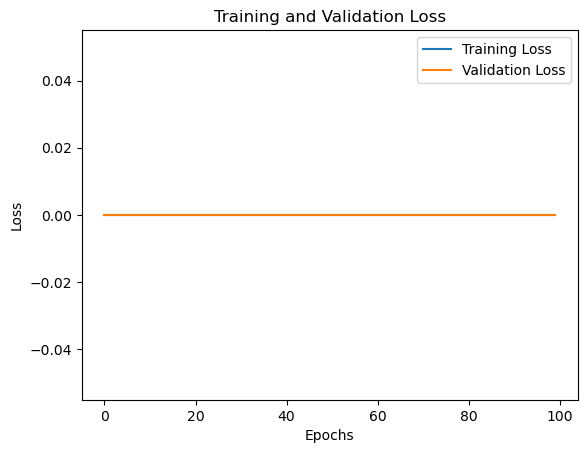

In [319]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [325]:
history_df.head(25)

,accuracy,loss
2,0.967882,0.140325
3,1.000000,0.007004
4,1.000000,0.001966
5,1.000000,0.000913
6,1.000000,0.000519
7,1.000000,0.000329
8,1.000000,0.000223
9,1.000000,0.000159
10,1.000000,0.000117
11,1.000000,0.000089


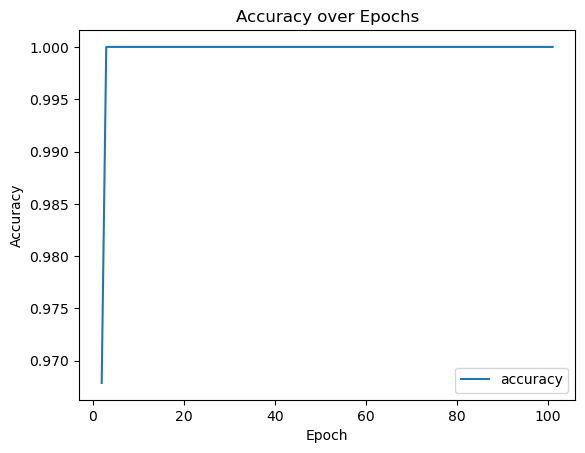

In [323]:
import matplotlib.pyplot as plt

# Assuming history_df is a DataFrame containing the training history

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the accuracy
history_df.plot(y="accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.show()


In [329]:
def do_inferencing(model, data):
    # Your code to run inference
    predictions = model.predict(data)
    return predictions


In [331]:
predictions = nn_model.predict(X_test_scaled)


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [333]:
predictions[0]

array([ 10.018228, -13.837724], dtype=float32)

In [335]:
np.argmax(predictions[0])

0

In [345]:
# Define the patient control list
patient_control = ["unfiltered control", "filtered control"]

# Get the actual label from y_test and make sure it's accessible in df_renamed
# Ensure the label is an integer that corresponds to the index correctly
actual_label = df_renamed.loc[df_renamed['patient'] == y_test[5], 'patient'].values[0]

# Get the predicted label using np.argmax for the prediction
predicted_label = patient_control[np.argmax(predictions[5])]

# Print the actual and predicted labels for patient #6
print(f"Patient #6: Actual Label = {actual_label} \t Predicted Label = {predicted_label}")


Patient #6: Actual Label = 1 	 Predicted Label = filtered control


------------------------------------

In [350]:
def do_inferencing(model, data):
    """
    Perform inference (prediction) on the given data using the provided model.
    
    Parameters:
    model (keras.Model): The trained Keras model.
    data (numpy.array or DataFrame): The input data to predict on.

    Returns:
    numpy.array: Predicted labels (or probabilities, depending on your model).
    """
    predictions = model.predict(data)  # Get predictions from the model
    predicted_classes = np.argmax(predictions, axis=1)  # Convert predictions to class labels
    return predicted_classes


In [357]:
# Assuming `nn_model` is your trained model and `X_test_scaled` is your test data
predicted_labels = do_inferencing(nn_model, X_test_scaled)

# Print out predictions for the first few test samples
print(f"Predicted labels for the first few test samples: {predicted_labels[:20]}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Predicted labels for the first few test samples: [0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
